## Introduction

Jupyter notebooks are divided into cells that can contain [markdown](https://daringfireball.net/projects/markdown/) or code that you can run interactively from the notebook interface. You can progress through the cells in the notebook by clicking the play button  in the notebook tab's toolbar.

Click the play button to advance to the next cell and continue on in the lab whenever you have completed a cell.

After clicking the play button, the status in the left-hand side of the bottom statusbar will change from Idle to Busy. Wait for the status to change back to Idle before proceeding to the next cell.

### Notebook Overview

This notebook works through the main steps that are shared by most machine learning projects:

- preparing data
- training a model
- hosting the model
- Using the hosted model for inference

You will use Python 3 as the programming language. This notebook is built on the SageMaker notebook conda_python3 environment. conda refers to [Anaconda](https://www.anaconda.com/distribution/) which is a data science platform. The environment comes with many common Python machine learning and data science libraries already installed. 

You will also use a built-in SageMaker algorithm for training the model as well as use SageMaker's model hosting capability to deploy the trained model to learn how to leverage SageMaker in your machine learning code.

## Understanding the Machine Learning Objective

In this notebook you will work with [US flight delay data](https://www.transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time) to develop a model that can forecast flight delays. You will create a regression model to forecast the number of minutes a given flight will be delayed.

## Preparing the Data

Raw flight delay data is provided to you in an Amazon S3 bucket. The data you will use is a sample of the total flight data available in order to keep the runtimes reasonably short for a more fluid lab experience.

In [1]:
%%time
import urllib.request

# Download the data from S3 to the notebook instance (~100MB of data)
source = "https://clouda-labs-assets.s3-us-west-2.amazonaws.com/sagemaker-notebooks/Flights.csv"
filepath = "Flights.csv"
urllib.request.urlretrieve(source, filepath)

CPU times: user 279 ms, sys: 207 ms, total: 486 ms
Wall time: 2.07 s


('Flights.csv', <http.client.HTTPMessage at 0x7ffa442cb8d0>)

The data is in comma-separated value (CSV) format. You will now inspect a few rows of the data to understand the features and sample values in the raw data.

In [2]:
with open(filepath) as file:
   line = file.readline()
   count = 1
   while count <= 5:
       print("Line {}: {}".format(count, line))
       line = file.readline()
       count += 1

Line 1: "YEAR","QUARTER","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","UNIQUE_CARRIER","TAIL_NUM","FL_NUM","ORIGIN","DEST","CRS_DEP_TIME","DEP_TIME","DEP_DELAY","DEP_DELAY_NEW","DEP_DEL15","DEP_DELAY_GROUP","CRS_ARR_TIME","ARR_DELAY","CRS_ELAPSED_TIME","DISTANCE","DISTANCE_GROUP"

Line 2: 2017,4,10,15,7,"VX","N844VA","1174","SFO","EWR","0805","0833",28.00,28.00,1,1,"1630",2.00,325.00,2565.00,11

Line 3: 2017,4,11,23,4,"B6","N529JB","470","FLL","BOS","0713","0706",-7.00,0.00,0,-1,"1017",-20.00,184.00,1237.00,5

Line 4: 2017,2,6,23,5,"UA","N19130","1815","IAH","SFO","1320","1324",4.00,4.00,0,0,"1526",-3.00,246.00,1635.00,7

Line 5: 2017,1,3,21,2,"AA","N183AA","628","CLT","PHX","1300","1257",-3.00,0.00,0,-1,"1435",-23.00,275.00,1773.00,8



__Line 1__ of the CSV file is the header which gives the names of each column in the file. The arrival delay (__ARR_DELAY__) column is the target you want to predict. The other columns are a variety of features for identifying the flight including the origin (__ORIGIN__) and destination (__DEST__) airports, date features (__YEAR__, __QUARTER__, etc.). The following lines show sample values for the features.

To get the most value from the data, you need to consider each feature's data type. The following dictionary 

You will use the [Python Data Analysis Library](https://pandas.pydata.org), or `pandas`, to load the CSV data into a `DataFrame` (`df`) that is easy to manipulate. To do so, you need to provide `pandas` with data types (`dtypes`) for each of the features. [`pandas` supports several data types](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dtypes). The following dictionary maps each feature to a data type.

In [3]:
import numpy as np
import pandas as pd

dtypes = {
        "YEAR": np.int64,
        "QUARTER": "category",
        "MONTH": "category",
        "DAY_OF_MONTH": "category",
        "DAY_OF_WEEK": "category",
        "UNIQUE_CARRIER": "category",
        "TAIL_NUM": "category",
        "FL_NUM": "category",
        "ORIGIN": "category",
        "DEST": "category",
        "CRS_DEP_TIME": np.int64,
        "DEP_TIME": np.int64,
        "DEP_DELAY": np.float64,
        "DEP_DELAY_NEW": np.float64,
        "DEP_DEL15": np.int64,
        "DEP_DELAY_GROUP": np.int64,
        "CRS_ARR_TIME": np.int64,
        "ARR_DELAY": np.float64,
        "CRS_ELAPSED_TIME": np.float64,
        "DISTANCE": np.float64,
        "DISTANCE_GROUP": "category"
    }

It is not always obvious which data type to use for a feature. The provided types are reasonable but in practice it may be worth trying different data types to see which yields the best results when it is not clear.

The [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function can now create a DataFrame from the csv data. 

In [4]:
%%time

df = pd.read_csv(filepath, dtype=dtypes)

CPU times: user 2.47 s, sys: 148 ms, total: 2.62 s
Wall time: 2.78 s


You can now explore the data to better understand each feature's statistics and distribution. For brevity, the following code only explores the target arrival delay. You can explore other features by extending the code if you desire.

count    1.114749e+06
mean     4.666474e+00
std      4.562534e+01
min     -2.350000e+02
25%     -1.400000e+01
50%     -6.000000e+00
75%      8.000000e+00
max      1.935000e+03
Name: ARR_DELAY, dtype: float64

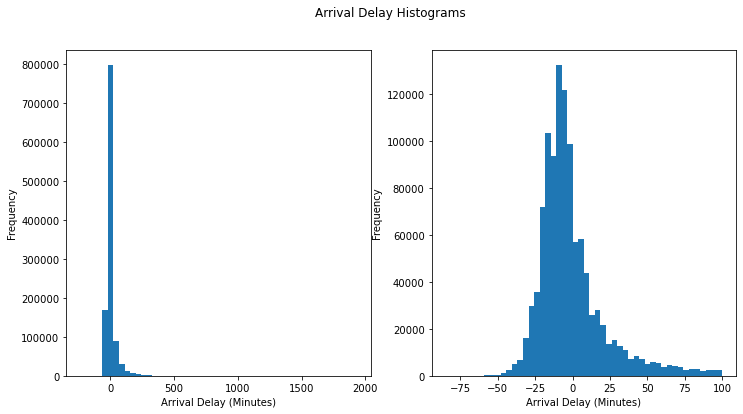

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot histogram of all arrival delays and arrival delays between -100 (100 minutes early) and 100
fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Arrival Delay Histograms')
axes[0].hist(df['ARR_DELAY'], bins=50)
axes[0].set(ylabel='Frequency', xlabel='Arrival Delay (Minutes)');

delays_zoom = df.loc[(df['ARR_DELAY'] >= -100) & (df['ARR_DELAY'] <= 100), 'ARR_DELAY']
axes[1].hist(delays_zoom, bins=50)
axes[1].set(ylabel='Frequency', xlabel='Arrival Delay (Minutes)');

# Print arrival delay statistics
df['ARR_DELAY'].describe()

There is a wide range of arrival delays with the largest delay being 1935 minutes. The average delay is 4.7 minutes. The majority of flights arrive early (50th percentile is -6 minutes).

Some features will not be included in the model to reduce the training time for the sake of this lab and because some features are not expected to correlate with the target. For example, the __YEAR__ is always 2017 in the sample data so it has not value in predicting delay.

In [6]:
drop_columns = ["YEAR", "TAIL_NUM", "FL_NUM", "DEST"]
df = df.drop(columns=drop_columns)

The SageMaker algorithm you will use, linear-learner, only supports numerical feature values. You must encode the categorical features because of this restriction. There are several ways to encode categorical features into numerical features but you will use one-hot encoding which replaces a categorical feature with one feature for each possible value of the encoded feature. This does result in an increase in the number of features which can impact training times.

In [7]:
%%time

categoricals = [column for (column, dtype) in dtypes.items() if dtype == "category" and column in df.columns]
for column in categoricals:
    df = pd.get_dummies(data=df, columns=[column])

CPU times: user 5.12 s, sys: 1.01 s, total: 6.13 s
Wall time: 6.43 s


After one-hot encoding the categorical features the number of features has increased to 402 from 21.

In [8]:
df.shape

(1114749, 402)

Had some of the columns not been dropped the number would be significantly higher. For example, the __TAIL_NUM__ feature is a unique number assigned to each aircraft. In the data set there are over 4000 aircrafts which would result in over 4000 features being added with one-hot encoding. For this lab you assume there is no correlation between specific aircrafts and arrival delay by dropping the column.

The data is all numerical now but the the linear-learner SageMaker algorithm requires either [CSV or RecordIO protobuf formatted data](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html). `pandas` has a [`to_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) function that can be used for outputting the DataFrame as a CSV file. The SageMaker Python library includes a function for creating the [RecordIO formatted data](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/amazon/common.py#L132). You will use the CSV format. You will upload the training data to an S3 bucket created for you by the Cloud Academy lab environment. SageMaker can also access training data on AWS Elastic File Systems (EFS) or AWS FSx for Lustre (FSxLustre).

In [9]:
import boto3
import io
import sagemaker.amazon.common as smac

# Get the available S3 bucket created by the Cloud Academy lab environment
bucket = boto3.client('s3').list_buckets()['Buckets'][0]['Name']
print(bucket)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


cloudacademylabs-sagemakerdata-chz65gskw1w4


The data will be split into training and test sets. The test set will be used by SageMaker to test the performance of the trained model using data that isn't part of the training process. You will then write the CSV files.

_Warning_: It takes 5-10 minutes to complete.

In [10]:
%%time

# Place target in first column for SageMaker training with CSV files
columns = df.columns.tolist()
columns.remove("ARR_DELAY")
columns.insert(0, "ARR_DELAY")
df = df[columns]

# Split data into training and test sets (60%/40% deterministic split)
train = df.sample(frac=0.6, random_state=1) # fix random_state for consistent results
test = df.drop(train.index)
del df

# Write CSV files
train.to_csv(path_or_buf='train.csv', header=False, index=False) # don't write header or row indexes (index=False)
test.to_csv(path_or_buf='test.csv', header=False, index=False)

CPU times: user 52.9 s, sys: 1.4 s, total: 54.3 s
Wall time: 1min 1s


The files can now be uploaded to S3.

In [11]:
%%time

import os

prefix = 'FlightDelays'
key = 'csv-data'

# Upload data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_file('train.csv', ExtraArgs={'ContentType': 'text/csv'})
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_file('test.csv', ExtraArgs={'ContentType': 'text/csv'})
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded testing data location: {}'.format(s3_test_data))

uploaded training data location: s3://cloudacademylabs-sagemakerdata-chz65gskw1w4/FlightDelays/train/csv-data
uploaded testing data location: s3://cloudacademylabs-sagemakerdata-chz65gskw1w4/FlightDelays/test/csv-data
CPU times: user 5.82 s, sys: 4.27 s, total: 10.1 s
Wall time: 6.71 s


## Training the Model

Now that the training data is available on S3 in a format that SageMaker can use, you are ready to train the model. You will use the [linear-learner algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) for training. The linear-learner algorithm can be used for regression or classification problems. It scales to large data sets and is sufficient for demonstrating the use of built-in SageMaker algorithms using Python.

SageMaker algorithms are available via container images. Each region that supports SageMaker has its own copy of the images. You will begin by retreiving the URI of the container image for the current session's region. 

In [12]:
from sagemaker import image_uris

container = image_uris.retrieve('linear-learner', boto3.Session().region_name)
container

'174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:1'

From the image URI you can see the images are stored in Elastic Container Registry (ECR). You can also make your own images to use with SageMaker and store them in ECR.

You will configure a training job next.

In [13]:
import sagemaker

# Store the output in the S3 bucket
s3_output = 's3://{}/{}/output'.format(bucket, prefix)

# Retrieve the notebooks role and use it for model training (has access to S3, SageMaker)
role = sagemaker.get_execution_role()

session = sagemaker.Session()

# Use the Estimator interface to configure a training job
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count=1, 
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output,
                                       sagemaker_session=session,
                                       input_mode='Pipe' # stream training data from S3
                                       )

Pipe mode is used for faster training and allows data to be streamed directly from S3 as opposed to File mode which downloads the entire data files before any training. It is [supported for CSV files](https://aws.amazon.com/blogs/machine-learning/now-use-pipe-mode-with-csv-datasets-for-faster-training-on-amazon-sagemaker-built-in-algorithms/) after it was originally only for RecordIO protobuf format.

You must now configure the [hyperparameters for the linear-learner algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html). You will only configure the required hyperparameters, however for production models it is worth tuning and considering other hyperparameters.

In [14]:
linear.set_hyperparameters(feature_dim=len(train.columns) - 1, # minus 1 for the target
                           predictor_type='regressor')

The training job can now begin training the model. The time to provision the training instance and perform the actual training together take around 8 minutes. You can monitor the progress of the training job as it is output below the following cell. Blue logs represent logs coming from the training container and summarize the progress of the training process. The job is finished when you see __Completed - Training job completed__.

In [15]:
%%time

import time

# Set the content_type to text/csv (default is application/x-recordio-protobuf)
train_channel = sagemaker.session.TrainingInput(s3_train_data, content_type='text/csv')
test_channel = sagemaker.session.TrainingInput(s3_test_data, content_type='text/csv')

name = f"flight-delays-{int(time.time())}"

linear.fit({'train': train_channel, 'test': test_channel}, job_name=name) # validation channel is also supported

2022-04-26 03:43:33 Starting - Starting the training job...
2022-04-26 03:43:58 Starting - Preparing the instances for trainingProfilerReport-1650944613: InProgress
.........
2022-04-26 03:45:16 Downloading - Downloading input data...
2022-04-26 03:45:56 Training - Downloading the training image...
2022-04-26 03:46:32 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/26/2022 03:46:40 INFO 140656904480576 integration.py:636] worker started
[04/26/2022 03:46:40 INFO 140656904480576] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init

Near the end of the training container logs you can see the __#test_score__ logs which show the performance of the model on the test set. The mean-squared error (__mse__) is 164.38. Taking the square root gives 12.8 loosely meaning that the model had an error of around 12 minutes for its test set predictions on average.

## Deploying the Trained Model

SageMaker can host models through its hosting services. The model is accessible to client through a SageMaker endpoint. The hosted model, endpoint configuration resource, and endpoint are all created with a single function call `deploy()`. The process takes around 5 minutes including the time to create an instance to host the model. You will see a __!__ output when everything is finished.

In [16]:
%%time

linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

-------------!CPU times: user 209 ms, sys: 14 ms, total: 223 ms
Wall time: 6min 31s


## Using the Endpoint for Inference

The Endpoint is accessible over HTTPS but when using the SageMaker Python SDK you can use the `predict` function to abstract the complexity of HTTPS requests. You first configure how the predictor is to serialize requests and deserialize responses. You will use CSV to serialize requests and JSON to deserialize responses.

In [17]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

You will now use the model endpoint to make a prediciton using a sample vector from the test data.

In [18]:
test_vector = test.iloc[0][1:] # use all but the first column (first column is actual delay)
actual_delay = test.iloc[0][0]

response = linear_predictor.predict(test_vector)

predicted_delay = response['predictions'][0]['score']
print(f'Predicted {predicted_delay}, actual {actual_delay}, error {actual_delay-predicted_delay}')

Predicted -12.270792007446289, actual -20.0, error -7.729207992553711


In this case the prediction is within eight minutes of the actual delay.

## Summary

You have now seen how to use Python to prepare data, use SageMaker to train and deploy a model, and make predictions with a model hosted in SageMaker. 

This concludes the notebook. Return to the Cloud Academy lab browser tab to complete the lab.